<a href="https://colab.research.google.com/github/linhhvo/machine-learning-assignments/blob/master/rnn/LinhVo_HW5_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM, Dropout, GlobalAveragePooling1D
import re
import string
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

path = "/content/drive/My Drive/CS733-HW5/" 
os.chdir(path)

dataset_orig = pd.read_csv("Tweets.csv")
dataset_orig.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.700000e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/2015 11:35,NaN,Eastern Time (US & Canada)
1,5.700000e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
2,5.700000e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/2015 11:15,Lets Play,Central Time (US & Canada)
3,5.700000e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
4,5.700000e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/2015 11:14,NaN,Pacific Time (US & Canada)


In [ ]:
# Keep only relevant columns
dataset = dataset_orig[['airline_sentiment', 'text']]

# Drop rows with 'neutral' sentiment
dataset = dataset[dataset['airline_sentiment'] != 'neutral']

# Add 'polarity' column and set value to be 1 if sentiment is positive and 0 otherwise
dataset['polarity'] = np.where(dataset['airline_sentiment'] == 'positive', 1, 0)

print(dataset.shape)
dataset.head()

(11541, 3)


,airline_sentiment,text,polarity
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [ ]:
# Only keep 'text' and 'polarity' columns to train model
df = dataset[['text', 'polarity']]

pd.options.display.max_colwidth = 10000
df

,text,polarity
1,@VirginAmerica plus you've added commercials to the experience... tacky.,1
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
4,@VirginAmerica and it's a really big bad thing about it,0
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,0
6,"@VirginAmerica yes, nearly every time I fly VX this â€œear wormâ€ wonâ€™t go away :)",1
...,...,...
14633,"@AmericanAir my flight was Cancelled Flightled, leaving tomorrow morning. Auto rebooked for a Tuesday night flight but need to arrive Monday.",0
14634,@AmericanAir right on cue with the delaysðŸ‘Œ,0
14635,@AmericanAir thank you we got on a different flight to Chicago.,1
14636,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,0


# Part 1

### Preprocessing dataset

In [ ]:
# Create a custom standardization function .
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,'[%s]' % re.escape(string.punctuation), '')

# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to 
# integers. Note that the layer uses the custom standardization defined above. 
# Set maximum_sequence length as all samples are not of the same length.
vectorization_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_dataset = df['text'].to_numpy()
vectorization_layer.adapt(text_dataset)

In [ ]:
vocab = np.array(vectorization_layer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'to', 'the', 'i', 'a', 'united', 'you', 'for',
       'flight', 'and', 'on', 'my', 'usairways', 'americanair', 'is',
       'in', 'southwestair', 'of', 'jetblue'], dtype='<U160')

In [ ]:
print(df.iloc[1, 0])
encoded_review = vectorization_layer(df.text)
print(encoded_review[2].numpy())
print(f"\nIndex 69 refers to the word '{vocab[69]}'")
print(f"\nIndex 10 refers to the word '{vocab[10]}'")

@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
[100  10  69   5 120 435 193 475  86  22   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]

Index 69 refers to the word 'its'

Index 10 refers to the word 'and'


In [ ]:
# Shuffle dataset
df = df.sample(frac=1).reset_index(drop=True)
df

,text,polarity
0,"@AmericanAir I'll be sticking with @southwest in the future. No change fees, first bag free, and stellar customer service.",0
1,@united cldnt be happier w the many plastic wing pins given to me on flight 494. I love them! Amazing staff! So nice http://t.co/CbV7f3KBKx,1
2,@USAirways Ever sit on hold and just lose track of time? http://t.co/Yqhk8LJaBN,0
3,@JetBlue There's just so many choices for y'all south of the border and I know not every airline is equal - lowest price != best value. ;),1
4,@AmericanAir my husband and 5 year old son stuck overnight in DC thanks to 7 crew members arguing over who was boarding the flight,0
...,...,...
11536,@USAirways 1899. Thanks,1
11537,@SouthwestAir So frustrated with my experience with #Southwest. 18 hours trapped in Denver bc of mechanical problems. #worstcustomerservice,0
11538,@AmericanAir United needs our ticket number since you rebooked us and you gave the incorrect ticket number now we can't check in #help,0
11539,@USAirways But every time I call I'm on hold for 45 min and then get disconnected. Any way someone can help?,0


In [ ]:
# Split data into training and testing sets
training_end_index = round(len(df) * .8)
train_dataset = df.iloc[:training_end_index, :]
test_dataset = df.iloc[training_end_index:, :]

train_text = train_dataset.text.to_numpy()
train_label = train_dataset.polarity.to_numpy()
test_text = test_dataset.text.to_numpy()
test_label= test_dataset.polarity.to_numpy()

### Train and evaluate model 1

In [ ]:
embedding_dim = 64

model_1 = tf.keras.Sequential([
    vectorization_layer,
    Embedding(vocab_size, embedding_dim, mask_zero=True),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

In [ ]:
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
history = model_1.fit(x=train_text, y=train_label, epochs=40, validation_split=0.1)

Epoch 1/40
260/260 [==============================] - 28s 41ms/step - loss: 0.5793 - accuracy: 0.7936 - val_loss: 0.5059 - val_accuracy: 0.7835
Epoch 2/40
260/260 [==============================] - 6s 25ms/step - loss: 0.4896 - accuracy: 0.7979 - val_loss: 0.5007 - val_accuracy: 0.7835
Epoch 3/40
260/260 [==============================] - 6s 25ms/step - loss: 0.4881 - accuracy: 0.7936 - val_loss: 0.4943 - val_accuracy: 0.7835
Epoch 4/40
260/260 [==============================] - 6s 24ms/step - loss: 0.4778 - accuracy: 0.8001 - val_loss: 0.4867 - val_accuracy: 0.7835
Epoch 5/40
260/260 [==============================] - 6s 24ms/step - loss: 0.4727 - accuracy: 0.7964 - val_loss: 0.4796 - val_accuracy: 0.7835
Epoch 6/40
260/260 [==============================] - 7s 25ms/step - loss: 0.4696 - accuracy: 0.7978 - val_loss: 0.4721 - val_accuracy: 0.7835
Epoch 7/40
260/260 [==============================] - 6s 25ms/step - loss: 0.4590 - accuracy: 0.7981 - val_loss: 0.4677 - val_accuracy: 0.783

In [ ]:
train_loss, train_acc = model_1.evaluate(x=train_text, y=train_label)

print('Train Loss: {}'.format(train_loss))
print('Train Accuracy: {}'.format(train_acc))

test_loss, test_acc = model_1.evaluate(x=test_text, y=test_label)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

289/289 [==============================] - 3s 10ms/step - loss: 0.1908 - accuracy: 0.9278
Train Loss: 0.19077476859092712
Train Accuracy: 0.9277591109275818
73/73 [==============================] - 1s 10ms/step - loss: 0.2201 - accuracy: 0.9116
Test Loss: 0.22011196613311768
Test Accuracy: 0.911611795425415


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '') # for validation results
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

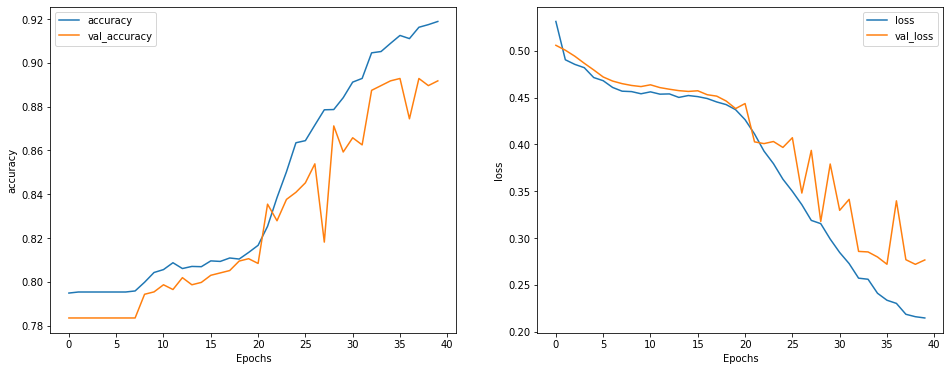

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# Part 2



### Preprocessing dataset

In [ ]:
# Make a copy of dataset
df_2 = df.copy()
df_2

,text,polarity
0,"@AmericanAir I'll be sticking with @southwest in the future. No change fees, first bag free, and stellar customer service.",0
1,@united cldnt be happier w the many plastic wing pins given to me on flight 494. I love them! Amazing staff! So nice http://t.co/CbV7f3KBKx,1
2,@USAirways Ever sit on hold and just lose track of time? http://t.co/Yqhk8LJaBN,0
3,@JetBlue There's just so many choices for y'all south of the border and I know not every airline is equal - lowest price != best value. ;),1
4,@AmericanAir my husband and 5 year old son stuck overnight in DC thanks to 7 crew members arguing over who was boarding the flight,0
...,...,...
11536,@USAirways 1899. Thanks,1
11537,@SouthwestAir So frustrated with my experience with #Southwest. 18 hours trapped in Denver bc of mechanical problems. #worstcustomerservice,0
11538,@AmericanAir United needs our ticket number since you rebooked us and you gave the incorrect ticket number now we can't check in #help,0
11539,@USAirways But every time I call I'm on hold for 45 min and then get disconnected. Any way someone can help?,0


In [ ]:
# Convert each tweet into a list of words
df_2['text'] = df_2['text'].str.split()

# Remove stop words
nltk.download('stopwords')
stops = set(stopwords.words("english"))                  

def remove_stops(row):
    text = row['text']
    filtered_text = [word for word in text if not word in stops]
    return (filtered_text)

# Reduce related words to a common stems
porter = PorterStemmer()

def stem_text(row):
    text = row['processed_text']
    stemmed_text = [porter.stem(word) for word in text]
    return (stemmed_text)

# Apply preprocessing functions to dataset and store values in separate columns
df_2['processed_text'] = df_2.apply(remove_stops, axis=1)
# df_2['stemmed_text'] = df_2.apply(stem_text, axis=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_2

,text,polarity,processed_text
0,"[@AmericanAir, I'll, be, sticking, with, @southwest, in, the, future., No, change, fees,, first, bag, free,, and, stellar, customer, service.]",0,"[@AmericanAir, I'll, sticking, @southwest, future., No, change, fees,, first, bag, free,, stellar, customer, service.]"
1,"[@united, cldnt, be, happier, w, the, many, plastic, wing, pins, given, to, me, on, flight, 494., I, love, them!, Amazing, staff!, So, nice, http://t.co/CbV7f3KBKx]",1,"[@united, cldnt, happier, w, many, plastic, wing, pins, given, flight, 494., I, love, them!, Amazing, staff!, So, nice, http://t.co/CbV7f3KBKx]"
2,"[@USAirways, Ever, sit, on, hold, and, just, lose, track, of, time?, http://t.co/Yqhk8LJaBN]",0,"[@USAirways, Ever, sit, hold, lose, track, time?, http://t.co/Yqhk8LJaBN]"
3,"[@JetBlue, There's, just, so, many, choices, for, y'all, south, of, the, border, and, I, know, not, every, airline, is, equal, -, lowest, price, !=, best, value., ;)]",1,"[@JetBlue, There's, many, choices, y'all, south, border, I, know, every, airline, equal, -, lowest, price, !=, best, value., ;)]"
4,"[@AmericanAir, my, husband, and, 5, year, old, son, stuck, overnight, in, DC, thanks, to, 7, crew, members, arguing, over, who, was, boarding, the, flight]",0,"[@AmericanAir, husband, 5, year, old, son, stuck, overnight, DC, thanks, 7, crew, members, arguing, boarding, flight]"
...,...,...,...
11536,"[@USAirways, 1899., Thanks]",1,"[@USAirways, 1899., Thanks]"
11537,"[@SouthwestAir, So, frustrated, with, my, experience, with, #Southwest., 18, hours, trapped, in, Denver, bc, of, mechanical, problems., #worstcustomerservice]",0,"[@SouthwestAir, So, frustrated, experience, #Southwest., 18, hours, trapped, Denver, bc, mechanical, problems., #worstcustomerservice]"
11538,"[@AmericanAir, United, needs, our, ticket, number, since, you, rebooked, us, and, you, gave, the, incorrect, ticket, number, now, we, can't, check, in, #help]",0,"[@AmericanAir, United, needs, ticket, number, since, rebooked, us, gave, incorrect, ticket, number, can't, check, #help]"
11539,"[@USAirways, But, every, time, I, call, I'm, on, hold, for, 45, min, and, then, get, disconnected., Any, way, someone, can, help?]",0,"[@USAirways, But, every, time, I, call, I'm, hold, 45, min, get, disconnected., Any, way, someone, help?]"


In [ ]:
# Join words back into sentences
def rejoin_words(row):
    text = row['processed_text']
    joined_words = ( " ".join(text))
    return joined_words

df_2['processed_text'] = df_2.apply(rejoin_words, axis=1) 

In [ ]:
# Drop unnecessary columns
df_2.drop(columns=['text'], inplace=True)
df_2

,polarity,processed_text
0,0,"@AmericanAir I'll sticking @southwest future. No change fees, first bag free, stellar customer service."
1,1,@united cldnt happier w many plastic wing pins given flight 494. I love them! Amazing staff! So nice http://t.co/CbV7f3KBKx
2,0,@USAirways Ever sit hold lose track time? http://t.co/Yqhk8LJaBN
3,1,@JetBlue There's many choices y'all south border I know every airline equal - lowest price != best value. ;)
4,0,@AmericanAir husband 5 year old son stuck overnight DC thanks 7 crew members arguing boarding flight
...,...,...
11536,1,@USAirways 1899. Thanks
11537,0,@SouthwestAir So frustrated experience #Southwest. 18 hours trapped Denver bc mechanical problems. #worstcustomerservice
11538,0,@AmericanAir United needs ticket number since rebooked us gave incorrect ticket number can't check #help
11539,0,@USAirways But every time I call I'm hold 45 min get disconnected. Any way someone help?


In [ ]:
# Create a custom standardization function to strip twitter usernames/handlers.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    removed_punctuation = tf.strings.regex_replace(lowercase,'[%s]' % re.escape(string.punctuation), '')
    removed_tweets_handle = tf.strings.regex_replace(removed_punctuation, '([@][\w_-]+)', '')
    return removed_tweets_handle

# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to 
# integers. Note that the layer uses the custom standardization defined above. 
# Set maximum_sequence length as all samples are not of the same length.
vectorization_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_dataset = df_2['processed_text'].to_numpy()
vectorization_layer.adapt(text_dataset)

In [ ]:
train_dataset_2 = df_2.iloc[:training_end_index, :]
test_dataset_2 = df_2.iloc[training_end_index:, :]

train_text_2 = train_dataset_2.processed_text.to_numpy()
train_label_2 = train_dataset_2.polarity.to_numpy()
test_text_2 = test_dataset_2.processed_text.to_numpy()
test_label_2= test_dataset_2.polarity.to_numpy()

### Train and evaluate model 2

In [ ]:
embedding_dim = 64

model_2 = tf.keras.Sequential([
    vectorization_layer,
    Embedding(vocab_size, embedding_dim, mask_zero=True),
    # GlobalAveragePooling1D(),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='nadam',
              metrics=['accuracy'])

In [ ]:
earlystopper = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
history_2 = model_2.fit(x=train_text_2, y=train_label_2, epochs=40, validation_split=0.1, verbose=1)

Epoch 1/40
260/260 [==============================] - 29s 48ms/step - loss: 0.4092 - accuracy: 0.8299 - val_loss: 0.2701 - val_accuracy: 0.9037
Epoch 2/40
260/260 [==============================] - 8s 31ms/step - loss: 0.1375 - accuracy: 0.9516 - val_loss: 0.2668 - val_accuracy: 0.8994
Epoch 3/40
260/260 [==============================] - 8s 31ms/step - loss: 0.0839 - accuracy: 0.9711 - val_loss: 0.3445 - val_accuracy: 0.8896
Epoch 4/40
260/260 [==============================] - 8s 31ms/step - loss: 0.0426 - accuracy: 0.9879 - val_loss: 0.3758 - val_accuracy: 0.8918
Epoch 5/40
260/260 [==============================] - 8s 31ms/step - loss: 0.0317 - accuracy: 0.9915 - val_loss: 0.5028 - val_accuracy: 0.8874
Epoch 6/40
260/260 [==============================] - 8s 31ms/step - loss: 0.0249 - accuracy: 0.9928 - val_loss: 0.4714 - val_accuracy: 0.9004
Epoch 7/40
260/260 [==============================] - 8s 31ms/step - loss: 0.0181 - accuracy: 0.9943 - val_loss: 0.6890 - val_accuracy: 0.895

In [ ]:
train_loss, train_acc = model_2.evaluate(x=train_text_2, y=train_label_2, verbose=0)

print('Train Loss: {}'.format(train_loss))
print('Train Accuracy: {}'.format(train_acc))

print()
test_loss, test_acc = model_2.evaluate(x=test_text_2, y=test_label_2, verbose=0)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

Train Loss: 0.08720608055591583
Train Accuracy: 0.9815877676010132

Test Loss: 0.4260745346546173
Test Accuracy: 0.909878671169281


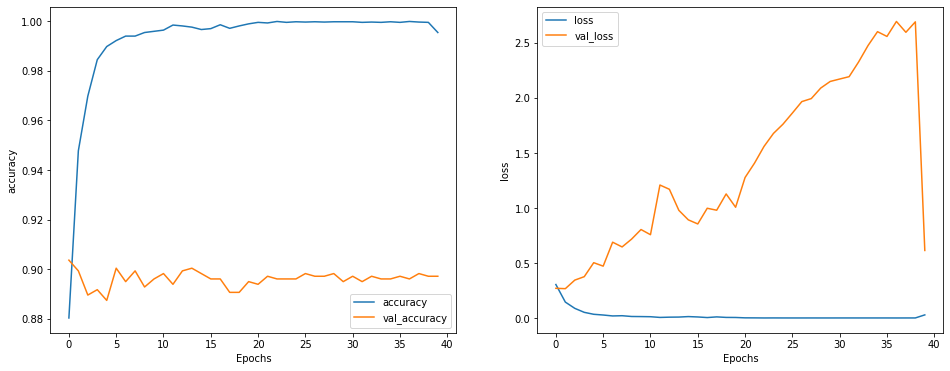

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history_2, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history_2, 'loss')